In [34]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import widgets
import glob

from connectivity import constants as const
from connectivity import visualize as vis
from connectivity import nib_utils as nio

%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# initialize directories
dirs = const.Dirs()

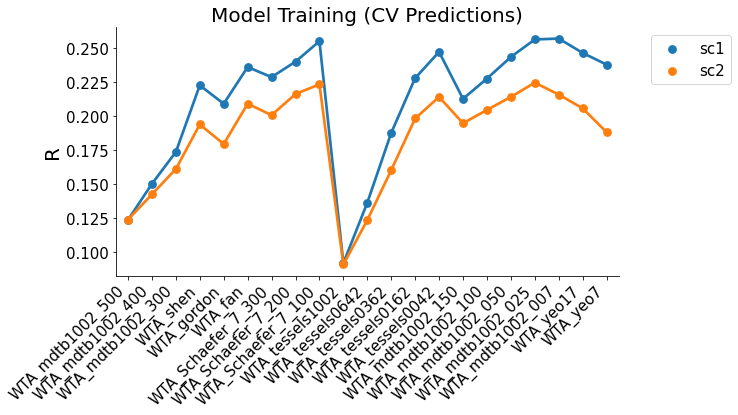

In [3]:
# plot alpha curve for train CVs
# WTA

df = vis.train_summary()

vis.plot_train_predictions(dataframe=df.query('train_model=="WTA"'), 
                               x='train_name', 
                               hue='train_exp'
                          ); 


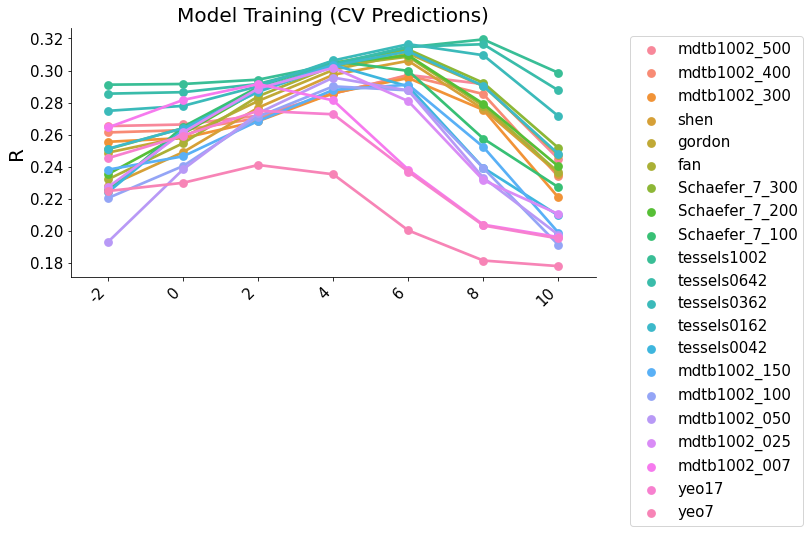

In [4]:
# RIDGE

vis.plot_train_predictions(dataframe=df.query('train_model=="L2regression"'), 
                               x='train_hyperparameter', 
                               hue='train_X_data'
                          )


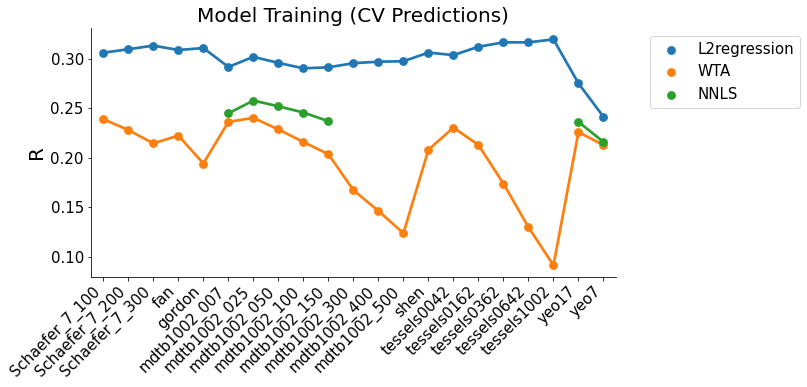

In [5]:
# compare methods (cv)

# get best model for each method
tmp = df.groupby(['train_X_data', 'train_model', 'train_hyperparameter']).mean().reset_index()

tmp1 = tmp.groupby(['train_X_data', 'train_model']
           ).apply(lambda x: x['train_R_cv'].max()
           ).reset_index(name='train_R_cv')


vis.plot_train_predictions(dataframe=tmp1, x='train_X_data', hue='train_model')

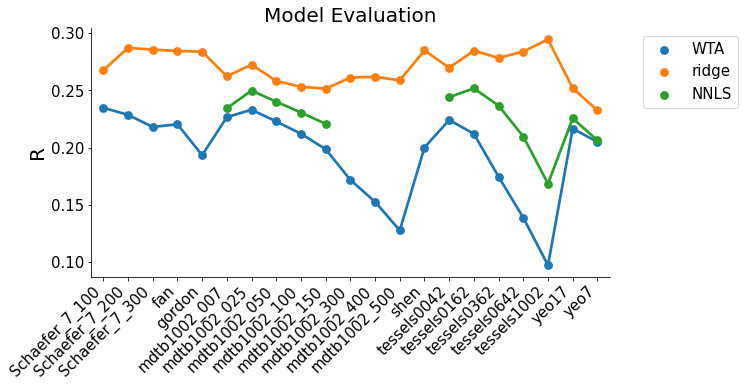

In [6]:
# compare methods (evaluation)

# get evaluation 
df_eval = vis.eval_summary()

df_eval['eval_model'] = df_eval['eval_name'].str.rsplit('_').str[0]

# get best model for each method
tmp = df_eval.groupby(['eval_X_data', 'eval_model']).mean().reset_index()

tmp1 = tmp.groupby(['eval_X_data', 'eval_model']
           ).apply(lambda x: x['R_eval'].max()
           ).reset_index(name='R_eval')


vis.plot_eval_predictions_all(dataframe=tmp1, x='eval_X_data', hue='eval_model')

best model for sc1 is ridge_tessels1002_alpha_8


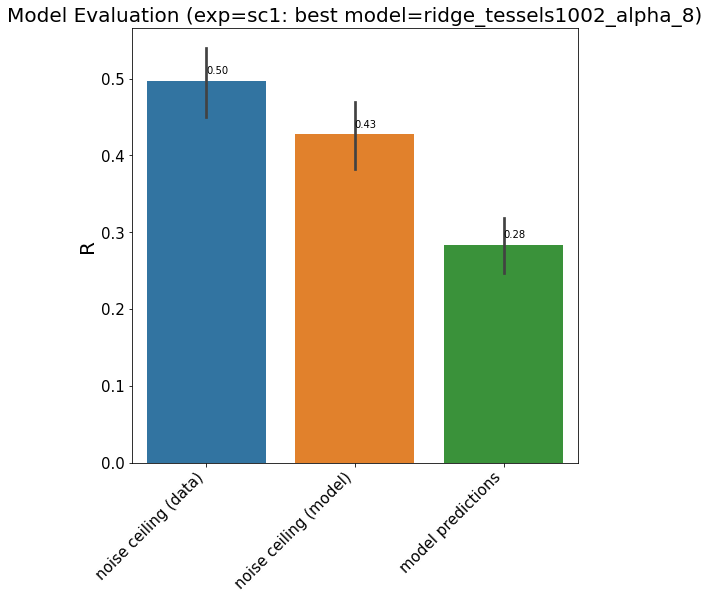

best model for sc2 is ridge_tessels1002_alpha_8


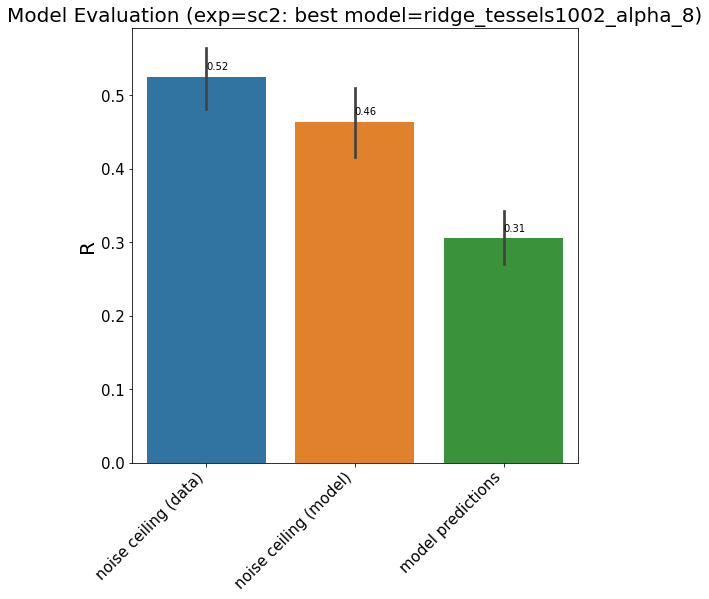

In [7]:
# Model evaluation (noise ceiling and predictions) - best model

# get evaluation 
df_eval = vis.eval_summary()

for exp in ['sc1', 'sc2']:
    
    #plot evaluation
    vis.plot_eval_predictions(dataframe=df_eval, exp=exp)

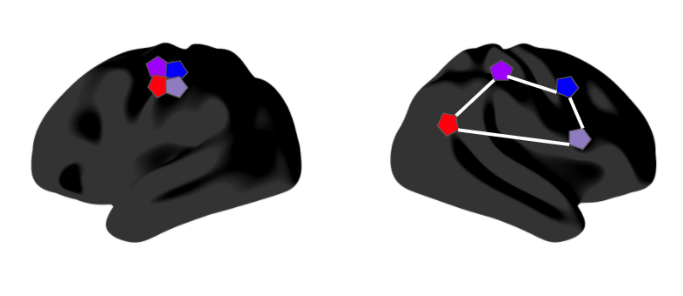

In [8]:
import matplotlib.image as mpimg

fname = os.path.join(dirs.figure, 'sparsity.png')

fig = plt.figure(figsize=(12,12))
img = mpimg.imread(fname)
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
@widgets.interact(roi=['yeo7', 'yeo17', 'mdtb1002_007'])

def distance_matrix(roi):
    vis.show_distance_matrix(roi)

interactive(children=(Dropdown(description='roi', options=('yeo7', 'yeo17', 'mdtb1002_007'), value='yeo7'), Ou…

interactive(children=(Dropdown(description='structure', options=('cerebellum', 'cortex'), value='cerebellum'),…

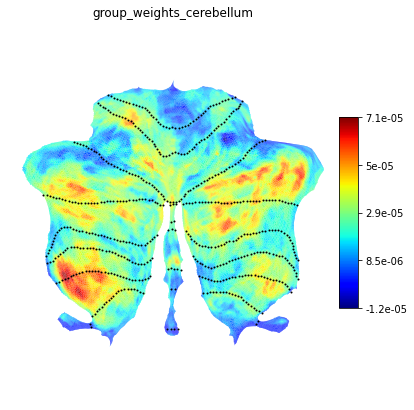

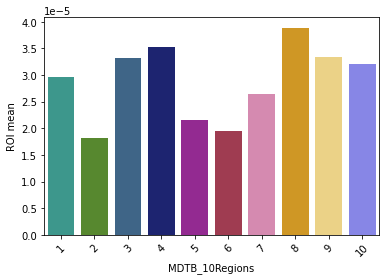

In [35]:
# visualize model weights - cerebellum or cortex

exp = 'sc1'

model, _ = vis.get_best_models(train_exp=exp)
model.insert(0,'best_model')

@widgets.interact(structure=['cerebellum', 'cortex'],
                 model_name=model,
                 hemisphere=[None, 'R', 'L'], 
                 colorbar=[True, False],
                 roi_summary=[True, False])

def map_weights(structure, model_name, hemisphere, colorbar, roi_summary):
    view = vis.map_weights(structure, exp, model_name, hemisphere, rois=roi_summary)

interactive(children=(Dropdown(description='data', options=('R', 'R2', 'noiseceiling_XY_R', 'noiseceiling_Y_R'…

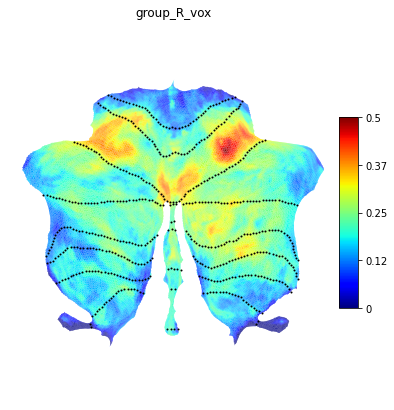

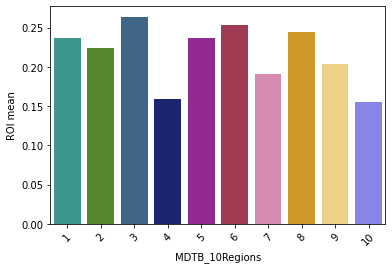

In [44]:
# visualize model evaluations

exp = 'sc1'

model, _ = vis.get_eval_models(exp=exp)
model.insert(0,'best_model')

@widgets.interact(data=['R','R2',
                        'noiseceiling_XY_R',
                        'noiseceiling_Y_R'],
                 model_name=model,
                 colorbar=[True, False],
                 roi_summary=[True, False],
                 atlas=['MDTB_10Regions', 'atl-Anatom_sp-SUIT', 'atl-Buckner7_sp-SUIT'])

def map_eval(data, model_name, colorbar, roi_summary, atlas):
    view = vis.map_eval(data, exp, model_name, colorbar, rois=roi_summary, atlas=atlas)

In [47]:
# visualize model comparisons (binary or subtract)

exp = 'sc1'

_, cortex_names = vis.get_eval_models(exp=exp)

@widgets.interact(model_name=cortex_names, 
                 method=['subtract', 'binarize'],
                 colorbar=[False, True],
                 roi_summary=[True, False],
                 atlas=['MDTB_10Regions', 'atl-Anatom_sp-SUIT', 'atl-Buckner7_sp-SUIT'])

def plot_difference(model_name, method, colorbar, roi_summary, atlas):
    view = vis.map_model_comparison(model_name, exp, method, colorbar, rois=roi_summary, atlas=atlas)
    

In [ ]:
# plot parcellation - cerebellum
@widgets.interact(parcellation=nio.get_cerebellar_atlases())

def plot_parcellation(parcellation):
    view = vis.map_atlas(parcellation, structure='cerebellum')

In [ ]:
# plot parcellation - cortex

@widgets.interact(parcellation=nio.get_cortical_atlases())

def plot_parcellation(parcellation):
    view = vis.map_atlas(parcellation, structure='cortex')